In [ ]:
# CUSTOMER CHURN PREDICTION FOR TELCO

In [1]:
# upload dataset
from google.colab import files
uploaded = files.upload()

Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn.csv


In [2]:
import pandas as pd
import numpy as np

# ML & preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, classification_report

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Load CSV (adjust filename if different)
churn = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
churn.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# Quick checks
print(churn.shape)
churn.info()
churn.describe(include='all').T

# Check churn balance
print(churn['Churn'].value_counts())
print(churn['Churn'].value_counts(normalize=True))


(7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null

In [4]:
# confirming unique values in churn
churn['Churn'].unique()

array(['No', 'Yes'], dtype=object)

In [5]:
# adjustments
if 'TotalCharges' in churn.columns:
    churn['TotalCharges'] = pd.to_numeric(churn['TotalCharges'].replace(" ", np.nan))

# Target mapping
churn['Churn'] = churn['Churn'].map({'Yes':1, 'No':0})

# Quick missing values
churn.isna().sum()


,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [6]:
# feature groups [num vs cat]
num_cols = churn.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = churn.select_dtypes(include=['object','category']).columns.tolist()
# remove target if accidentally included
if 'Churn' in num_cols: num_cols.remove('Churn')
if 'Churn' in cat_cols: cat_cols.remove('Churn')

print("Numerical:", num_cols)
print("Categorical:", cat_cols)


Numerical: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Categorical: ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [7]:
# building preprocessing pipeline
# numeric transformer: impute median + scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# categorical transformer: impute constant + one-hot
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])


In [8]:
# train/test split
X = churn.drop(columns=['Churn'])
y = churn['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(X_train.shape, X_test.shape, y_train.mean(), y_test.mean())


(5634, 20) (1409, 20) 0.2653532126375577 0.2654364797728886


In [9]:
# Baseline Model: Logistic Regression

pipe_lr = Pipeline(steps=[
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=1000))
])

pipe_lr.fit(X_train, y_train)
lr_y_pred = pipe_lr.predict(X_test)
lr_y_proba = pipe_lr.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, lr_y_pred))
print("Precision:", precision_score(y_test, lr_y_pred))
print("Recall:", recall_score(y_test, lr_y_pred))
print("F1:", f1_score(y_test, lr_y_pred))
print("ROC-AUC:", roc_auc_score(y_test, lr_y_proba))
print(classification_report(y_test, lr_y_pred))


Accuracy: 0.8034066713981547
Precision: 0.6520376175548589
Recall: 0.5561497326203209
F1: 0.6002886002886003
ROC-AUC: 0.8417215634606938
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.65      0.56      0.60       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.80      0.80      0.80      1409



In [10]:
# Save LR [Logistic Regression] Results

# Predictions from pipeline
logistic_pred = pipe_lr.predict(X_test)
logistic_proba = pipe_lr.predict_proba(X_test)[:, 1]

# Create results dataframe using original test set
logistic_results = X_test.copy()

# Add prediction columns
logistic_results['Actual'] = y_test.values
logistic_results['Predicted'] = logistic_pred
logistic_results['Churn_Probability'] = logistic_proba

# Put customerID first if it exists
if 'customerID' in logistic_results.columns:
    logistic_results = logistic_results[['customerID'] +
                                        [col for col in logistic_results.columns if col != 'customerID']]

# Save FULL results
logistic_results.to_csv("logistic_full_predictions.csv", index=False)

logistic = pd.read_csv("logistic_full_predictions.csv")
logistic.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Actual,Predicted,Churn_Probability
0,4376-KFVRS,Male,0,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Two year,Yes,Credit card (automatic),114.05,8468.20,0,0,0.042215
1,2754-SDJRD,Female,1,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,Yes,Month-to-month,Yes,Credit card (automatic),100.15,908.55,0,1,0.690123
2,9917-KWRBE,Female,0,Yes,Yes,41,Yes,Yes,DSL,Yes,...,Yes,No,One year,Yes,Credit card (automatic),78.35,3211.20,0,0,0.058043


In [11]:
# SMOTE + LR

# recall is 56%. The model is only catching 56% of customers who actually churn
# losing almost half of churners before action
# smote + retrain - imbalanced -- !pip install imbalanced-learn
# smote cant handle strings

# smote cant handle strings
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# transform with preprocessing pipeline
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)


In [12]:
# applying smote to processed numeric data
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)

# training model on resampled data
model.fit(X_train_resampled, y_train_resampled)


LogisticRegression(max_iter=1000)

In [13]:
# predict n evaluate
smote_y_pred = model.predict(X_test_processed)
smote_y_proba = model.predict_proba(X_test_processed)[:, 1]


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# predictions already computed as above

smote_accuracy = accuracy_score(y_test, smote_y_pred)
smote_precision = precision_score(y_test, smote_y_pred)
smote_recall = recall_score(y_test, smote_y_pred)
smote_f1 = f1_score(y_test, smote_y_pred)
smote_roc_auc = roc_auc_score(y_test, smote_y_proba)

print("Accuracy:", smote_accuracy)
print("Precision:", smote_precision)
print("Recall:", smote_recall)
print("F1 Score:", smote_f1)
print("ROC-AUC:", smote_roc_auc)
print("\nClassification Report:")
print(classification_report(y_test, smote_y_pred))


Accuracy: 0.7615330021291696
Precision: 0.538
Recall: 0.7192513368983957
F1 Score: 0.6155606407322655
ROC-AUC: 0.8398796145599216

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.78      0.83      1035
           1       0.54      0.72      0.62       374

    accuracy                           0.76      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.79      0.76      0.77      1409



In [15]:
# Save SMOTE Results

X_test_smote = X_test.copy()
X_test_smote['Actual'] = y_test.values
X_test_smote['Predicted'] = smote_y_pred
X_test_smote['Churn_Probability'] = smote_y_proba


# Save full dataset
X_test_smote.to_csv("smote_logistic_full_predictions.csv", index=False)
smote_lr = pd.read_csv("smote_logistic_full_predictions.csv")
smote_lr.head(3)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Actual,Predicted,Churn_Probability
0,4376-KFVRS,Male,0,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Two year,Yes,Credit card (automatic),114.05,8468.20,0,0,0.078001
1,2754-SDJRD,Female,1,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,Yes,Month-to-month,Yes,Credit card (automatic),100.15,908.55,0,1,0.824759
2,9917-KWRBE,Female,0,Yes,Yes,41,Yes,Yes,DSL,Yes,...,Yes,No,One year,Yes,Credit card (automatic),78.35,3211.20,0,0,0.087592


In [16]:
# XGBOOST

# using xgboost
from xgboost import XGBClassifier

# train
xgb_churn = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb_churn.fit(X_train_resampled, y_train_resampled)

# predict & evaluate
y_pred = xgb_churn.predict(X_test_processed)
y_proba = xgb_churn.predict_proba(X_test_processed)[:, 1]



In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Evaluate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

# Print results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC-AUC:", roc_auc)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.7799858055358411
Precision: 0.5776699029126213
Recall: 0.6363636363636364
F1 Score: 0.6055979643765903
ROC-AUC: 0.8430145444211941

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.83      0.85      1035
           1       0.58      0.64      0.61       374

    accuracy                           0.78      1409
   macro avg       0.72      0.73      0.73      1409
weighted avg       0.79      0.78      0.78      1409



In [18]:
# Save XGBOOST Results
xgb_pred = xgb_churn.predict(X_test_processed)
xgb_proba = xgb_churn.predict_proba(X_test_processed)[:, 1]

# Create results dataframe using original test set
xgb_results = X_test.copy()

# Add prediction columns
xgb_results['Actual'] = y_test.values
xgb_results['Predicted'] = xgb_pred
xgb_results['Churn_Probability'] = xgb_proba


# Save FULL results
xgb_results.to_csv("xgboost_full_predictions.csv", index=False)

xgb = pd.read_csv("xgboost_full_predictions.csv")
xgb.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Actual,Predicted,Churn_Probability
0,4376-KFVRS,Male,0,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Two year,Yes,Credit card (automatic),114.05,8468.20,0,0,0.014003
1,2754-SDJRD,Female,1,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,Yes,Month-to-month,Yes,Credit card (automatic),100.15,908.55,0,1,0.878557
2,9917-KWRBE,Female,0,Yes,Yes,41,Yes,Yes,DSL,Yes,...,Yes,No,One year,Yes,Credit card (automatic),78.35,3211.20,0,0,0.057213


In [19]:
import pandas as pd

results = {
    "Model": ["Logistic", "SMOTE", "XGBoost"],
    "Recall (Churn)": [0.56, 0.72, 0.64],
    "Accuracy": [0.80, 0.76, 0.78],
    "ROC-AUC": [0.84, 0.84, 0.84]
}

churn_results = pd.DataFrame(results)
churn_results


,Model,Recall (Churn),Accuracy,ROC-AUC
0,Logistic,0.56,0.80,0.84
1,SMOTE,0.72,0.76,0.84
2,XGBoost,0.64,0.78,0.84


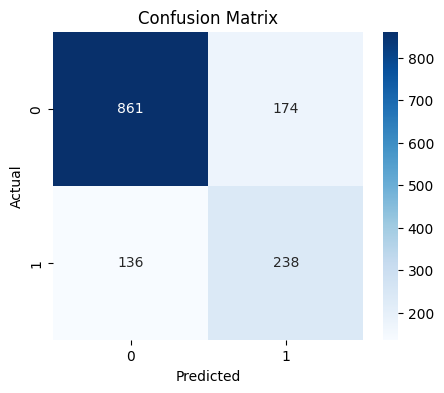

In [20]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


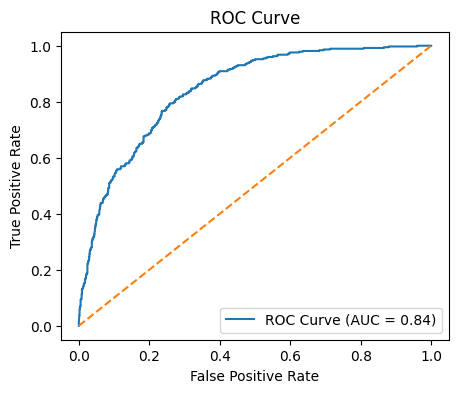

In [21]:
# ROC curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [22]:
import pandas as pd

# the 3 csvs
df_lr = pd.read_csv("logistic_full_predictions.csv")
df_smote = pd.read_csv("smote_logistic_full_predictions.csv")
df_xgb = pd.read_csv("xgboost_full_predictions.csv")

# Rename prediction cols to avoid conflicts after merge
df_lr = df_lr.rename(columns={"Predicted": "Logistic_Pred", "Churn_Probability": "Logistic_Prob"})
df_smote = df_smote.rename(columns={"Predicted": "Smote_Pred", "Churn_Probability": "Smote_Prob"})
df_xgb = df_xgb.rename(columns={"Predicted": "XGB_Pred", "Churn_Probability": "XGB_Prob"})

# Merge on customerID (inner join = only customers in test set)
df_master = df_lr.merge(df_smote[['customerID','Smote_Pred','Smote_Prob']], on="customerID", how="left")
df_master = df_master.merge(df_xgb[['customerID','XGB_Pred','XGB_Prob']], on="customerID", how="left")

# Adding MODEL AGREEMENT score
df_master["Model_Agreement"] = (df_master["Logistic_Pred"] + df_master["Smote_Pred"] + df_master["XGB_Pred"])/3

# save final comparison CSV
df_master.to_csv("churn_model_comparison.csv", index=False)

# preview result
df_master.head(3)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,MonthlyCharges,TotalCharges,Actual,Logistic_Pred,Logistic_Prob,Smote_Pred,Smote_Prob,XGB_Pred,XGB_Prob,Model_Agreement
0,4376-KFVRS,Male,0,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,...,114.05,8468.20,0,0,0.042215,0,0.078001,0,0.014003,0.0
1,2754-SDJRD,Female,1,No,No,8,Yes,Yes,Fiber optic,No,...,100.15,908.55,0,1,0.690123,1,0.824759,1,0.878557,1.0
2,9917-KWRBE,Female,0,Yes,Yes,41,Yes,Yes,DSL,Yes,...,78.35,3211.20,0,0,0.058043,0,0.087592,0,0.057213,0.0


In [25]:
!pip install pyngrok
!pip install streamlit


In [23]:
%%writefile app.py
import streamlit as st
import pandas as pd
import plotly.express as px
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# Load CSV
df = pd.read_csv("churn_model_comparison.csv")

st.title("Customer Churn Prediction Dashboard")
st.write("Compare Logistic Regression, SMOTE Logistic, and XGBoost predictions")

model_choice = st.sidebar.selectbox(
    "Select Model View",
    ("Logistic", "SMOTE Logistic", "XGBoost")
)

pred_col = f"{model_choice}_Pred"
proba_col = f"{model_choice}_Prob"

top_churners = df[df[pred_col] == 1].sort_values(by=proba_col, ascending=False)

# Metrics
y_true = df['Actual']
y_pred = df[pred_col]
y_prob = df[proba_col]

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_prob)

st.subheader(f"Model Metrics: {model_choice}")
st.write(f"**Accuracy:** {accuracy:.2f}")
st.write(f"**Precision:** {precision:.2f}")
st.write(f"**Recall:** {recall:.2f}")
st.write(f"**ROC-AUC:** {roc_auc:.2f}")

# Table of top churners
st.subheader(f"Top Churners Predicted by {model_choice}")
st.dataframe(top_churners[['customerID', 'gender', 'tenure', 'MonthlyCharges', 'TotalCharges', pred_col, proba_col]])

# Bar chart: Monthly Charges of top churners
fig1 = px.bar(top_churners.head(20), x='customerID', y='MonthlyCharges', color='MonthlyCharges',
              title=f"Monthly Charges of Top 20 Predicted Churners ({model_choice})")
st.plotly_chart(fig1, use_container_width=True)

# Bar chart: Total Charges of top churners
fig2 = px.bar(top_churners.head(20), x='customerID', y='TotalCharges', color='TotalCharges',
              title=f"Total Charges of Top 20 Predicted Churners ({model_choice})")
st.plotly_chart(fig2, use_container_width=True)


Writing app.py


In [48]:
import shutil

# List all files you want to download
files_to_download = [
    "app.py",
    "churn_model_comparison.csv",
    "logistic_full_predictions.csv",
    "smote_logistic_full_predictions.csv",
    "xgboost_full_predictions.csv"
]

# Create a zip
shutil.make_archive("churn_dashboard_files", 'zip', root_dir='.', base_dir='.')


'/content/churn_dashboard_files.zip'

In [49]:
from google.colab import files

files.download("churn_dashboard_files.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>